<h2> Actor Critic Model </h2>

<p> Scenario 1: </p>
    <ul>
    <li> There is no amount limit </li>
    <li> There are no service charges for stock transactions </li>
    <li> The number of shares to buy in each transaction = 1 </li>
    <li> An episode terminates when all given data are tested </li>
    <li> The training step = 1 day </li>
    <li> The training takes more than half a day because the agent is required to test all the data samples in each episode. </li>

In [ ]:
#reference text
#https://books.google.com.sg/books?id=HnetDwAAQBAJ&pg=PT710&lpg=PT710&dq=replay+buffer+keras&source=bl&ots=kOYzzExOB5&sig=ACfU3U3A3YbvM4DuqReHvK1aYEtiDIpKUQ&hl=en&sa=X&ved=2ahUKEwiLtoHTk6zpAhXbeisKHUpCDkoQ6AEwA3oECAgQAQ#v=onepage&q=replay%20buffer%20keras&f=false
#https://towardsdatascience.com/how-to-train-your-quadcopter-adventures-in-machine-learning-algorithms-e6ee5033fd61
#https://towardsdatascience.com/understanding-and-implementing-distributed-prioritized-experience-replay-horgan-et-al-2018-d2c1640e0520
#https://github.com/PacktPublishing/Python-Reinforcement-Learning-Projects
#https://github.com/germain-hug/Deep-RL-Keras

In [1]:
from keras import layers, models, optimizers,regularizers,initializers
from keras import backend as K
import numpy as np
import pandas as pd
from numpy.random import choice
import random
from collections import namedtuple,deque
import math
import matplotlib.pyplot as plt

Using TensorFlow backend.


<h2> Understand Data </h2>

In [2]:
train_path =  'data/SPY_training.csv'
test_path = 'data/SPY_test.csv'

In [3]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [4]:
df = df_train.append(df_test)
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
# Remove spacing from columns headers
df.columns = [str(x).replace(' ', '_') for x in df.columns]
# Sort by datetime
df.sort_values(by='Date', inplace=True, ascending=True)
df.head(5)

,Date,Open,High,Low,Close,Adj_Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500


In [5]:
print("the date range of training dataset: ",df_train['Date'].min(), df_train['Date'].max())
print("the date range of test dataset: ",df_test['Date'].min(), df_test['Date'].max())

the date range of training dataset:  1993-01-29 2018-12-31
the date range of test dataset:  2019-01-02 2020-05-08


In [6]:
print("the size of training dataset: ", df_train.shape)
print("the size of test dataset: ",df_test.shape)
print ("the size of complete dataset: ",df.shape)

the size of training dataset:  (6528, 7)
the size of test dataset:  (341, 7)
the size of complete dataset:  (6869, 7)


In [7]:
print(df. describe())

              Open         High          Low        Close    Adj_Close  \
count  6869.000000  6869.000000  6869.000000  6869.000000  6869.000000   
mean    139.093952   139.916955   138.182487   139.093162   114.767321   
std      65.539873    65.795507    65.266381    65.548151    70.531779   
min      43.343750    43.531250    42.812500    43.406250    25.981276   
25%      98.580002    99.489998    97.470001    98.519997    71.126038   
50%     126.250000   127.080002   125.330002   126.160004    93.850166   
75%     165.600006   166.309998   164.860001   165.740005   144.523026   
max     337.790009   339.079987   337.480011   338.339996   336.362091   

             Volume  
count  6.869000e+03  
mean   8.476451e+07  
std    9.771849e+07  
min    5.200000e+03  
25%    7.437300e+06  
50%    5.766680e+07  
75%    1.225063e+08  
max    8.710263e+08  


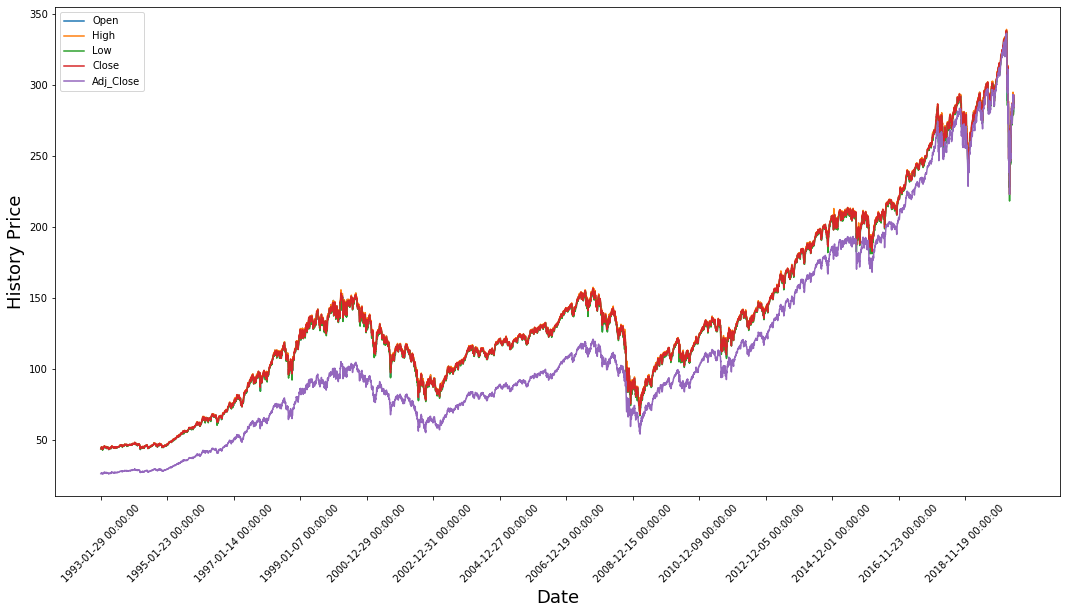

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Open']))
plt.plot(range(df.shape[0]),(df['High']))
plt.plot(range(df.shape[0]),(df['Low']))
plt.plot(range(df.shape[0]),(df['Close']))
plt.plot(range(df.shape[0]),(df['Adj_Close']))
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('History Price',fontsize=18)
plt.legend(['Open','High','Low','Close','Adj_Close'], loc='upper left')
plt.show()

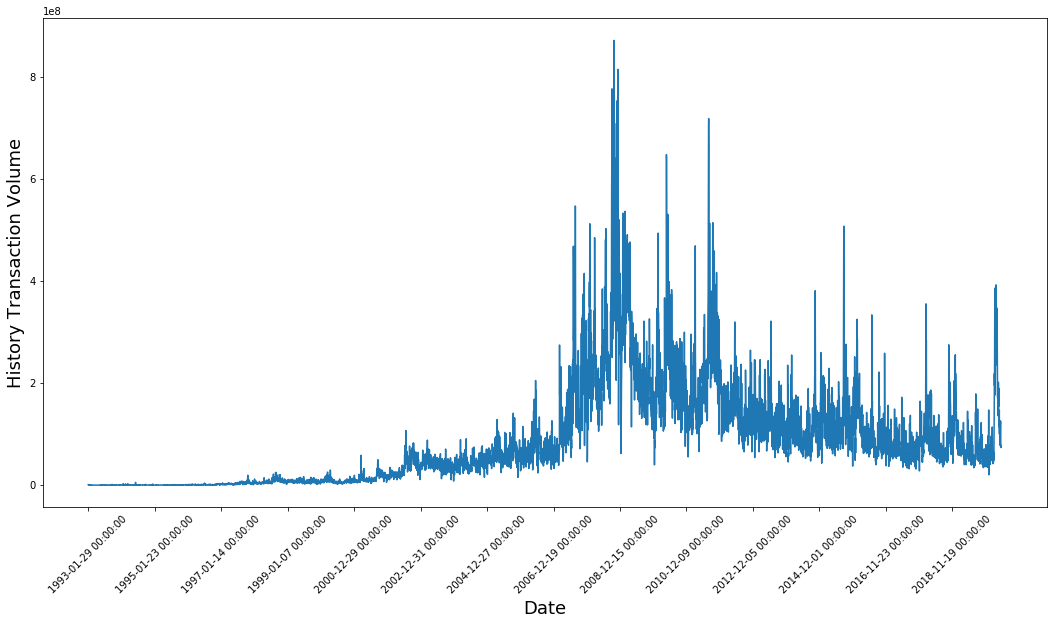

In [9]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Volume']))
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('History Transaction Volume',fontsize=18)
plt.show()

<p>The trend of open, high, low, close and adj close is similar<p>
<p>It seems when there is a price drop, there is a volume surge <p>

In [10]:
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64


<h4> Actor Network</h4> 
<p> Purpose: Define the actor (policy) model.The actor could be a neural network taking observations (states) as inputs and outputting one possible action. </p>
<p> Possible Improvements: Policy Search Improvement: When the policy space is big,finding a good set of parameters via brute force search is diffcult, in that case genetic algorithm can be used for more efficient policy search. Example: create a first generation of 100 random policies, evaluate their performance and remove 80 bad policies.Then make the surviving policies to cross-over and mutate to produce the second generation. Then the process iterates until an acceptable solution is found. </p>

In [11]:
#the aim of the training is to maximise the discounted accumulative rewards & minimise the negatives of Q-value
#could switch the model to keras sequential model
class Actor:
    def __init__(self, state_size, action_size):
        self. state_size = state_size
        self. action_size = action_size
        self. build_model()
    
    def build_model(self):
        #add states as the inputs
        states = layers.Input(shape=(self.state_size,), name='states')
        #dimensionality of the first output space=16 (16 neurons)
        net = layers.Dense(units=16,kernel_regularizer=regularizers.l2(1e-6))(states) 
        net = layers.BatchNormalization()(net) #Normalize and scale inputs which allows each layer of a network to learn by itself a little bit more independently of other layers
        net = layers.Activation("relu")(net)
        #dimensionality of the second output space= 32 (32 neurons)
        net = layers.Dense(units=32,kernel_regularizer=regularizers.l2(1e-6))(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)  
        #dimensionality of the third output space= number of possible actions, each action is predicted with an probability
        actions = layers.Dense(units=self.action_size, activation='softmax', name = 'actions')(net)
        #the models class groups layers into an object with training and inference features.
        self.model = models.Model(inputs=states, outputs=actions)
        #model.save('data/actor_model')
        #define the loss function by using the action value (Q_value) gradients, for policy evaluation 
        action_gradients = layers.Input(shape=(self.action_size,))
        loss = K.mean(-action_gradients * actions) #the aims is to minimise the negatives of Q-values
        #define the optimizer and train the function
        optimizer = optimizers.Adam(lr=.0001)
        updates_op = optimizer.get_updates(params=self.model.trainable_weights, loss=loss)
        self.train_fn = K.function(inputs=[self.model.input, action_gradients, K.learning_phase()],outputs=self.model.output,updates=updates_op)


<h4> Critic Network </h4>
<p> Purpose: Build a critic (value) network that maps state and action pairs
(Q_values) </p>

In [12]:
class Critic:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.build_model()

    def build_model(self):
        states = layers.Input(shape=(self.state_size,), name='states')
        actions = layers.Input(shape=(self.action_size,), name='actions')
        net_states = layers.Dense(units=16,kernel_regularizer=regularizers.l2(1e-6))(states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Activation("relu")(net_states)
        #two inputs dense to same shapes
        net_states = layers.Dense(units=32, kernel_regularizer=regularizers.l2(1e-6))(net_states)
        net_actions = layers.Dense(units=32,kernel_regularizer=regularizers.l2(1e-6))(actions)
        #add the two inputs
        net = layers.Add()([net_states, net_actions])
        net = layers.Activation('relu')(net)
        #the final output layer will produce the Q-value state -action value
        Q_values = layers.Dense(units=1, name='q_values',kernel_initializer=initializers.RandomUniform(minval=-0.003, maxval=0.003))(net)
        self.model = models.Model(inputs=[states, actions], outputs=Q_values)
        optimizer = optimizers.Adam(lr=0.0001)
        self.model.compile(optimizer=optimizer, loss='mse')
        action_gradients = K.gradients(Q_values, actions)
        self.get_action_gradients = K.function(inputs=[*self.model.input, K.learning_phase()],outputs=action_gradients)

<h4> Agent </h4>
<p> Purpose: define an agent to train the actor and critic </p>

In [13]:
'''instead of training the DQN on the latest experiences, we will store all experiences in a replay buffer
   or a replay memory and we will sample a random training from it at each training iteration. This helps to reduce
   the correlation between the experiences in a training batch, which tremendously help training.
'''
# prioritized Experience Replay /importance sampling (sample important experiences more frequently)
#https://towardsdatascience.com/understanding-and-implementing-distributed-prioritized-experience-replay-horgan-et-al-2018-d2c1640e0520

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    #Add a new experience to the replay buffer memory
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    # randomly sample states from a memory buffer to improve overfitting
    def sample(self, batch_size=32):
        return random.sample(self.memory, k=self.batch_size)
    #Return the current size of the buffer memory
    def __len__(self):
        return len(self.memory)

<p>Possible Improvements: Policy Gradient </p>

In [14]:
#learns via actor and agent networks
class Agent:
    def __init__(self, state_size, batch_size, is_eval = False):
        #replay memory size
        self.state_size = state_size
        self.action_size = 3 #3 actions: buy, sell, hold
        self.buffer_size = 1000000
        self.batch_size = batch_size
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)
        self.inventory = []
        self.share= []
        #whether or not training is ongoing. This variable will be changed during the training and evaluation phase
        self.is_eval = is_eval 
        #discount factor in Bellman equation
        self.gamma = 0.99
        #a soft update of the actor and critic networks
        self.tau = 0.001
        #the actor policy model maps states to actions
        self.actor_local = Actor(self.state_size, self.action_size)
        self.actor_target = Actor(self.state_size, self.action_size)
        self.actor_target.model.set_weights(self.actor_local.model.get_weights()) #sets the target model parameters to local model parameters
        #the critic (value) model  maps the state-action pairs to Q_values 
        self.critic_local = Critic(self.state_size, self.action_size)
        self.critic_target = Critic(self.state_size, self.action_size)
        self.critic_target.model.set_weights(self.critic_local.model.get_weights()) 
    
    #the function will return the actions with probability distributions, given a state, using the actor (policy) network
    #the action with highest probability is the best action to given the state (best action to take)
    def act(self, state):
        options = self.actor_local.model.predict(state)
        self.last_state = state
        if not self.is_eval:
            return choice(range(3), p = options[0])
        return np.argmax(options[0])
    
    #the function will assign a stochastic policy, based on the action probabilities in the training model
    #the function will assign a deterministic action corresponding to the maximum probability in the testing model
    #the function will return the set of actions carried by the agent in each episode (all steps are recorded)
    def step(self, action, reward, next_state, done):
        self.memory.add(self.last_state, action, reward, next_state, done) #adds a new experience to the memory
        if len(self.memory) > self.batch_size: #when enough experiences are presented in memory for training 
            experiences = self.memory.sample(self.batch_size)# a ranfom sample will be pulled for training 
            self.learn(experiences) #the agent then learns from the sample experience
            self.last_state = next_state #update the state to next state
    
    #the function will learned the sampled experiences through the actor and the critic
    def learn(self, experiences):               
        states = np.vstack([e.state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)    
        actions = np.vstack([e.action for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        dones = np.array([e.done for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)

        actions_next = self.actor_target.model.predict_on_batch(next_states)
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states, actions_next])
        
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        self.critic_local.model.train_on_batch(x = [states, actions], y=Q_targets)
        
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states, actions, 0]),(-1, self.action_size))
        self.actor_local.train_fn([states, action_gradients, 1])
        self.soft_update(self.critic_local.model, self.critic_target.model)  
        self.soft_update(self.actor_local.model, self.actor_target.model)
    
    #the function performs soft updates on the model parameters to avoid drastic model changes
    def soft_update(self, local_model, target_model):
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())

        assert len(local_weights) == len(target_weights)

        new_weights = self.tau * local_weights + (1 - self.tau) * target_weights
        target_model.set_weights(new_weights)


<h4> Utility Functions </h4>

In [15]:
#utility functions
def formatPrice(n):
    if n >= 0:
        curr = "$"
    else:
        curr = "-$"
    return curr + "{0:.2f}".format(abs(n))


def getStockData(key):
    datavec = []
    lines = open("data/" + key + ".csv", "r").read().splitlines()
    
    for line in lines[1:]:
        datavec.append(float(line.split(",")[4]))
    
    return datavec
  
#The function for this takes three parameters: the data; a time, t (the day that you want to predict); 
#and a window (how many days to go back in time)
def getState(data, t, window):
    if t - window >= -1:
        vec = data[t - window + 1:t + 1]
    else: 
        vec = -(t-window+1)*[data[0]]+data[0: t + 1]
    #Nscale the state vector from 0 to 1 with a sigmoid function.
    #The sigmoid function can map any input value, from 0 to 1. This helps to normalize the values to probabilities.
    scaled_state = []
    for i in range(window - 1):
        scaled_state.append(1/(1 + math.exp(vec[i] - vec[i+1])))
    
    return np.array([scaled_state])

<h4> Train and Test </h4>

In [ ]:
window_size = 100
batch_size = 32
agent = Agent(window_size, batch_size)
df_train = getStockData("SPY_training")
len_train = len(df_train) - 1
episode_count = 3
summary = []

for e in range(episode_count):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(df_train, 0, window_size + 1) #first state in an epsiode
    agent.inventory = []
    total_profit = 0
    done = False
    
    for t in range(len_train):
        action = agent.act(state)
        action_prob = agent.actor_local.model.predict(state)
        next_state = getState(df_train, t + 1, window_size + 1)
        reward = 0
        
        #every day, agent has to decide an action: buy,sell or hold
        #if action==0, there is no action needed to be carried out (hold the stock)
        #if the action =1, buy the stock on the day, the quantity is always set to 1
        if action == 1:
            agent.inventory.append(df_train[t])
            print("Buy:" + formatPrice(df_train[t]))
        #if the action ==2, sell some of the stocks bought previously
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(df_train[t] - bought_price, 0)
            total_profit += df_train[t] - bought_price
            print("sell: " + formatPrice(df_train[t]) + "| profit: " + formatPrice(df_train[t] - bought_price))
        if t == len_train - 1:
            done = True
        
        agent.step(action_prob, reward, next_state, done)
        state = next_state

        if done:
            print("------------------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("------------------------------------------")
            summary.append(total_profit)
            print(summary)

Episode 0/300
Buy: $44.25* 100
Buy: $44.34* 100
Sell: $44.81* 100 ,Profit: $51.77
Buy: $44.97* 100
Buy: $44.97* 100
Buy: $44.66* 100
Sell: $44.59* 100 ,Profit: $20.54
Sell: $43.47* 100 ,Profit: -$154.35
Buy: $43.56* 100
Buy: $43.69* 100
Buy: $44.25* 100
Sell: $44.41* 100 ,Profit: -$60.69
Buy: $44.88* 100
Buy: $44.75* 100
Sell: $45.75* 100 ,Profit: $104.80
Buy: $45.59* 100
Sell: $45.31* 100 ,Profit: $170.47
Sell: $44.78* 100 ,Profit: $104.90
Sell: $45.09* 100 ,Profit: $79.87
Sell: $44.09* 100 ,Profit: -$82.53
Sell: $44.91* 100 ,Profit: $11.13
Sell: $44.53* 100 ,Profit: -$110.70
------------------------------------------
Final Amount: -$3754.49
Total Profit: -$3754.49
------------------------------------------
[-3754.4874999999943]
Episode 1/300
Buy: $44.81* 100
Buy: $44.97* 100
Buy: $44.97* 100
Sell: $44.66* 100 ,Profit: -$20.09
Buy: $43.44* 100
Sell: $43.41* 100 ,Profit: -$160.59
Sell: $44.25* 100 ,Profit: -$76.30
Buy: $44.41* 100
Buy: $44.28* 100
Sell: $45.12* 100 ,Profit: $164.24
Buy

Buy: $44.81* 100
Buy: $45.00* 100
Buy: $44.97* 100
Buy: $44.97* 100
Buy: $44.66* 100
Buy: $44.72* 100
Buy: $44.94* 100
Buy: $44.59* 100
Sell: $43.56* 100 ,Profit: -$41.86
Sell: $45.75* 100 ,Profit: $145.43
Sell: $44.09* 100 ,Profit: -$29.41
Sell: $44.34* 100 ,Profit: -$51.31
Sell: $44.75* 100 ,Profit: -$29.48
Sell: $45.59* 100 ,Profit: $57.94
Sell: $44.88* 100 ,Profit: -$13.86
Sell: $44.50* 100 ,Profit: -$20.07
Sell: $46.56* 100 ,Profit: $179.72
Sell: $47.44* 100 ,Profit: $245.26
Sell: $46.59* 100 ,Profit: $195.34
------------------------------------------
Final Amount: -$3392.93
Total Profit: -$3392.93
------------------------------------------
[-3754.4874999999943, -4175.4437499999985, -4617.484375000002, -3944.359375000002, -3041.7249999999995, -4080.250000000002, -3630.625, -2768.584375, -2880.465625000003, -3213.446875, -3392.9312499999996]
Episode 11/300
Buy: $43.94* 100
Buy: $44.25* 100
Buy: $44.34* 100
Buy: $44.81* 100
Buy: $45.00* 100
Buy: $44.97* 100
Buy: $44.97* 100
Buy: $44

Sell: $45.27* 100 ,Profit: $22.04
Sell: $48.88* 100 ,Profit: $385.74
Sell: $50.70* 100 ,Profit: $599.62
Sell: $50.61* 100 ,Profit: $584.00
Sell: $53.94* 100 ,Profit: $928.98
Sell: $55.80* 100 ,Profit: $1227.23
Buy: $55.53* 100
Sell: $56.17* 100 ,Profit: $1267.82
Sell: $56.36* 100 ,Profit: $77.18
------------------------------------------
Final Amount: -$3930.31
Total Profit: -$3930.31
------------------------------------------
[-3754.4874999999943, -4175.4437499999985, -4617.484375000002, -3944.359375000002, -3041.7249999999995, -4080.250000000002, -3630.625, -2768.584375, -2880.465625000003, -3213.446875, -3392.9312499999996, -2853.540625, -2838.7984375, -2056.7125, -2400.573437499999, -37.24843749999968, -686.2656249999998, -2545.3421875, -3930.3109375000004]
Episode 19/300
Buy: $44.97* 100
Buy: $44.97* 100
Buy: $44.72* 100
Buy: $44.59* 100
Buy: $43.47* 100
Buy: $43.44* 100
Buy: $43.56* 100
Buy: $43.72* 100
Buy: $44.25* 100
Buy: $44.34* 100
Buy: $44.41* 100
Sell: $44.91* 100 ,Profit:

Buy: $44.91* 100
Buy: $45.83* 100
Sell: $45.00* 100 ,Profit: $86.12
Sell: $46.14* 100 ,Profit: $106.32
Sell: $46.53* 100 ,Profit: $176.60
Sell: $46.00* 100 ,Profit: -$29.60
Sell: $56.11* 100 ,Profit: $927.20
Sell: $56.16* 100 ,Profit: $978.76
Sell: $70.31* 100 ,Profit: $2542.97
Sell: $73.34* 100 ,Profit: $2836.42
Sell: $73.94* 100 ,Profit: $2803.54
Buy: $75.22* 100
Sell: $76.75* 100 ,Profit: $145.45
------------------------------------------
Final Amount: -$2266.15
Total Profit: -$2266.15
------------------------------------------
[-3754.4874999999943, -4175.4437499999985, -4617.484375000002, -3944.359375000002, -3041.7249999999995, -4080.250000000002, -3630.625, -2768.584375, -2880.465625000003, -3213.446875, -3392.9312499999996, -2853.540625, -2838.7984375, -2056.7125, -2400.573437499999, -37.24843749999968, -686.2656249999998, -2545.3421875, -3930.3109375000004, -1919.3453124999992, -2841.2499999999986, -3017.8328124999985, -341.9593750000008, -1608.9812500000016, -4683.045926800004

Sell: $44.72* 100 ,Profit: -$29.47
Buy: $45.75* 100
Sell: $45.69* 100 ,Profit: -$10.82
Buy: $44.50* 100
Sell: $43.75* 100 ,Profit: -$79.38
Buy: $45.59* 100
Sell: $45.28* 100 ,Profit: -$35.78
Buy: $44.94* 100
Sell: $44.50* 100 ,Profit: -$48.20
Buy: $44.81* 100
Sell: $44.78* 100 ,Profit: -$7.60
Buy: $44.94* 100
Buy: $44.69* 100
Sell: $44.22* 100 ,Profit: -$76.30
Buy: $44.34* 100
Sell: $44.84* 100 ,Profit: $11.14
Sell: $44.91* 100 ,Profit: $51.76
Buy: $44.84* 100
Sell: $45.09* 100 ,Profit: $20.49
Buy: $44.91* 100
Sell: $44.97* 100 ,Profit: $1.75
------------------------------------------
Final Amount: -$4573.34
Total Profit: -$4573.34
------------------------------------------
[-3754.4874999999943, -4175.4437499999985, -4617.484375000002, -3944.359375000002, -3041.7249999999995, -4080.250000000002, -3630.625, -2768.584375, -2880.465625000003, -3213.446875, -3392.9312499999996, -2853.540625, -2838.7984375, -2056.7125, -2400.573437499999, -37.24843749999968, -686.2656249999998, -2545.342187

Buy: $61.41* 100
Sell: $62.31* 100 ,Profit: $84.39
Buy: $67.44* 100
Sell: $64.44* 100 ,Profit: -$306.44
Buy: $75.05* 100
Sell: $74.66* 100 ,Profit: -$46.53
Buy: $112.28* 100
Sell: $112.00* 100 ,Profit: -$39.33
Buy: $116.00* 100
Sell: $115.78* 100 ,Profit: -$33.45
------------------------------------------
Final Amount: -$12401.36
Total Profit: -$12401.36
------------------------------------------
[-3754.4874999999943, -4175.4437499999985, -4617.484375000002, -3944.359375000002, -3041.7249999999995, -4080.250000000002, -3630.625, -2768.584375, -2880.465625000003, -3213.446875, -3392.9312499999996, -2853.540625, -2838.7984375, -2056.7125, -2400.573437499999, -37.24843749999968, -686.2656249999998, -2545.3421875, -3930.3109375000004, -1919.3453124999992, -2841.2499999999986, -3017.8328124999985, -341.9593750000008, -1608.9812500000016, -4683.045926800004, -2266.1500000000005, -273.84062500000545, -3579.034375000005, -4663.037499999994, -4469.303124999994, -4107.784375000004, -4126.9562499

Sell: $201.21* 100 ,Profit: -$627.12
------------------------------------------
Final Amount: -$19922.72
Total Profit: -$19922.72
------------------------------------------
[-3754.4874999999943, -4175.4437499999985, -4617.484375000002, -3944.359375000002, -3041.7249999999995, -4080.250000000002, -3630.625, -2768.584375, -2880.465625000003, -3213.446875, -3392.9312499999996, -2853.540625, -2838.7984375, -2056.7125, -2400.573437499999, -37.24843749999968, -686.2656249999998, -2545.3421875, -3930.3109375000004, -1919.3453124999992, -2841.2499999999986, -3017.8328124999985, -341.9593750000008, -1608.9812500000016, -4683.045926800004, -2266.1500000000005, -273.84062500000545, -3579.034375000005, -4663.037499999994, -4469.303124999994, -4107.784375000004, -4126.9562499999965, -4573.337500000004, -209.17187499999727, -1239.8031249999956, -72.34374999999781, -849.5031250000113, -343.22031249999634, -12401.359374999996, -23672.598132199997, 44792.0421875, 50000, 50000, 50000, 50000, 50000, -199

------------------------------------------
Final Amount: -$4030.62
Total Profit: -$4030.62
------------------------------------------
[-3754.4874999999943, -4175.4437499999985, -4617.484375000002, -3944.359375000002, -3041.7249999999995, -4080.250000000002, -3630.625, -2768.584375, -2880.465625000003, -3213.446875, -3392.9312499999996, -2853.540625, -2838.7984375, -2056.7125, -2400.573437499999, -37.24843749999968, -686.2656249999998, -2545.3421875, -3930.3109375000004, -1919.3453124999992, -2841.2499999999986, -3017.8328124999985, -341.9593750000008, -1608.9812500000016, -4683.045926800004, -2266.1500000000005, -273.84062500000545, -3579.034375000005, -4663.037499999994, -4469.303124999994, -4107.784375000004, -4126.9562499999965, -4573.337500000004, -209.17187499999727, -1239.8031249999956, -72.34374999999781, -849.5031250000113, -343.22031249999634, -12401.359374999996, -23672.598132199997, 44792.0421875, 50000, 50000, 50000, 50000, 50000, -19922.720970699997, -8895.48125, -4030.625

In [ ]:
df_test = getStockData("SPY_training")
len_test = len(df_test) - 1
state = getState(df_test, 0, window_size + 1)
total_profit = 0
agent.inventory = []
agent.is_eval = False
done = False
summary_test = []

for t in range(len_test):
    action = agent.act(state)
    next_state = getState(df_test, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(df_test[t])
        print("Buy: " + formatPrice(df_test[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(df_test[t] - bought_price, 0)
        total_profit += df_test[t] - bought_price
        print("Sell: " + formatPrice(df_test[t]) + " | profit: " + formatPrice(df_test[t] - bought_price))

    if t == len_test - 1:
        done = True
    agent.step(action_prob, reward, next_state, done)
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")
        summary_test.append(total_profit)

In [ ]:
print (summary)

In [ ]:
print(summary_test)

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(summary) # plotting by columns
plt.xlabel('Training Episode',fontsize=18)
plt.ylabel('Profits Earned',fontsize=18)
plt.show()